# Second cleaning path

Now I want to be sure that my gps trace are for the run path only, meaning I want to remove gps point recorded before and after the run, in case I did not stop my watch.

## Import a few modules

In [1]:
import sys
import numpy as np
import pandas as pd
import gpxpy
import gpxpy.gpx
import matplotlib.pyplot as plt
import geopy.distance
import glob
import os
import importlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pickleshare
from datetime import datetime

pd.options.mode.copy_on_write = True

sys.path.append("../my_modules")
import toolToReadGPX as ttrgpx

startingPoint_df = pd.DataFrame(columns=["name","startingDate","latitude","longitude"], 
                                index=np.arange(4))
startingPoint_df.iloc[:,0] = ["Origin","Park Girouard","Park Doyon","Ciele"]
startingPoint_df.iloc[:,1] = ["2017-11-24", "2020-01-01","2021-11-21", "2022-11-24"]
startingPoint_df.iloc[:,2] = [45.46604,  45.471895, 45.4776919, 45.489528]
startingPoint_df.iloc[:,3] = [-73.6194,  -73.613628, -73.62141,  -73.567539]

startingPoint_df.head()

,name,startingDate,latitude,longitude
0,Origin,2017-11-24,45.46604,-73.6194
1,Park Girouard,2020-01-01,45.471895,-73.613628
2,Park Doyon,2021-11-21,45.477692,-73.62141
3,Ciele,2022-11-24,45.489528,-73.567539


# Load data

I have a list of file names and a list of DataFrame.

In [25]:
#
# list of file names
# 
path_csv_files = "../data/csv/"
list_csv_files  = glob.glob(path_csv_files+"*.csv")
list_csv_files.sort()

#
# list of panda DataFrame
#
list_run_df = []
for c, f in enumerate(list_csv_files):
    list_run_df.append(pd.read_csv(f))

#
# Create a new DataFrame to store information from each run
#  ----> that's the one I need to clean after cleaning a single gps trace
all_last_traces_info_df = pd.DataFrame(columns = ["time","cumulative_distance","indexNum"],
                                        index=[np.arange(len(list_run_df))])

for c, d in enumerate(list_run_df):
    # reselect the last point of trace corresponding to the final distance of the run
    idxmax_ = list_run_df[c]["cumulative_distance"].idxmax()
    # copy the values time and cumulative distance to the list of run
    all_last_traces_info_df.iloc[c,0:2] = list_run_df[c].iloc[idxmax_,[0,5]].copy() 
    # clean the time value to keep only yy mm dd
    all_last_traces_info_df.iloc[c,0] = str(all_last_traces_info_df.iloc[c,0][0:10]) 
    # add value to indexNum column
    all_last_traces_info_df.iloc[c,2] = c

# reformat the "time" column
all_last_traces_info_df["time"] = pd.to_datetime(all_last_traces_info_df['time'], format='%Y-%m-%d')

# add a new column as indexNum 0 to number of traces
all_last_traces_info_df['indexNum'] = np.arange(len(list_run_df))

# convert index to time index
all_last_traces_info_df = all_last_traces_info_df.set_index('time')

all_last_traces_info_df_before = all_last_traces_info_df.copy()

I have those variables on my workspace:
+ *list_csv_files* which is a list of csv file
+ *list_run_df* which a list of gps trace of the same number of element form the csv files
+ *all_last_trace_entree_df* which a DataFrame, one line per gps trace

In [3]:
index_longest_run = all_last_traces_info_df["cumulative_distance"].argmax()
one_long_run_df   = list_run_df[index_longest_run]
one_long_run_df.describe()

,latitude,longitude,elevation,distance,cumulative_distance,duration,cumulative_duration
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.000000
mean,45.492355,-73.580813,59.176000,2.228435,8252.520368,0.99,3056.190000
std,0.009643,0.015721,56.136564,1.534760,4359.179311,0.10,1787.729872
min,45.481113,-73.607131,17.700000,0.000000,0.000000,0.00,0.000000
25%,45.486093,-73.595256,20.300000,1.055911,4984.396963,1.00,1501.000000
50%,45.489470,-73.578151,26.550000,1.681807,8504.456346,1.00,3075.500000
75%,45.493263,-73.566660,80.600000,3.446669,11728.803859,1.00,4582.000000
max,45.520569,-73.557932,190.900000,6.671629,15767.277831,1.00,6085.000000


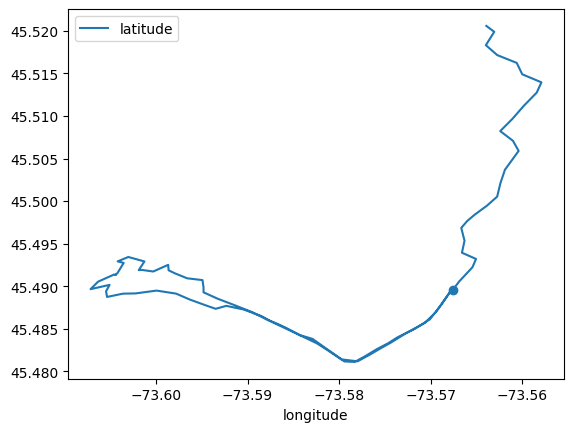

In [4]:
one_long_run_df.plot(x="longitude", y="latitude")
plt.scatter(startingPoint_df["longitude"][3],startingPoint_df["latitude"][3])

# What is the date of this run?

In [5]:
print(all_last_traces_info_df.index[index_longest_run].year, 
      all_last_traces_info_df.index[index_longest_run].month, 
      all_last_traces_info_df.index[index_longest_run].day)

2022 12 16


I can see on the graph that I have recorded my run before the *official* start of the run. 

I need to *clean* this gps trace:
+ detect which points I need to remove
+ update the corresponding DataFrame
+ update the other dataFrame 

In [6]:
importlib.reload(ttrgpx)

one_long_run_df   = list_run_df[index_longest_run]
index_ = ttrgpx.fun_clean_trace_start_end(one_long_run_df, startingPoint_df["longitude"][3],startingPoint_df["latitude"][3])
print(index_)
# now drop index 0 to 27
one_long_run_df = one_long_run_df.drop(np.arange(0,index_))
one_long_run_df = one_long_run_df.reset_index()

one_long_run_df["cumulative_distance"] = one_long_run_df["cumulative_distance"] - one_long_run_df["cumulative_distance"].loc[0]
one_long_run_df.index

27


RangeIndex(start=0, stop=73, step=1)

In [7]:
print(one_long_run_df["cumulative_distance"].iloc[-1] / 1000)
# replace cumulative value
all_last_traces_info_df.iloc[index_longest_run,0] = one_long_run_df["cumulative_distance"].iloc[-1]
# check the output
all_last_traces_info_df.iloc[index_longest_run-2: index_longest_run+3]

10.348233638706697


,cumulative_distance,indexNum
time,,
2022-12-02,8394.062073,35
2022-12-09,10929.646709,36
2022-12-16,10348.233639,37
2022-12-23,11271.669661,38
2023-01-20,11376.852666,39


2023 9 15
15485.326612887868


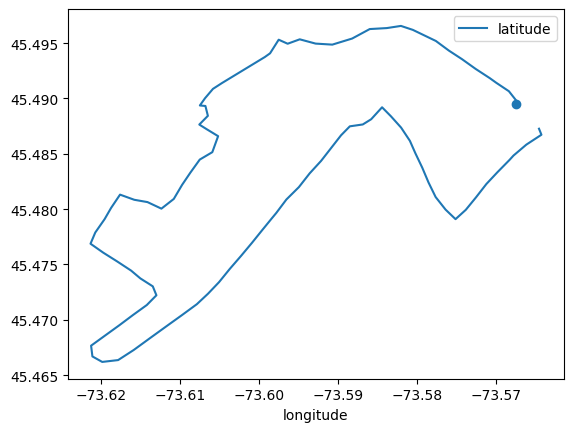

In [8]:
# re-search for the longest run
index_longest_run = all_last_traces_info_df["cumulative_distance"].argmax()
one_long_run_df   = list_run_df[index_longest_run]

one_long_run_df.plot(x="longitude", y="latitude")
plt.scatter(startingPoint_df["longitude"][3],startingPoint_df["latitude"][3])

print(all_last_traces_info_df.index[index_longest_run].year, all_last_traces_info_df.index[index_longest_run].month, all_last_traces_info_df.index[index_longest_run].day)

print(all_last_traces_info_df["cumulative_distance"].iloc[index_longest_run])

# Do a full check up of the gps traces

And if the starting point is not correct then drop the non-necessary points

In [9]:
if (all_last_traces_info_df.index[1] < pd.to_datetime("2024-01-01")):
    print("yes")
else:
    print("no")

yes


In [10]:
date_ = all_last_traces_info_df.index[0]
if date_ < pd.to_datetime(startingPoint_df["startingDate"][1]):
    print(startingPoint_df["longitude"][0])

In [11]:
startingPoint_df

,name,startingDate,latitude,longitude
0,Origin,2017-11-24,45.46604,-73.6194
1,Park Girouard,2020-01-01,45.471895,-73.613628
2,Park Doyon,2021-11-21,45.477692,-73.62141
3,Ciele,2022-11-24,45.489528,-73.567539


In [27]:
for c, single_trace_df in enumerate(list_run_df):
    #--> single_trace_df is equivalent to list_run_df[c]

    # check date for the starting point reference ref_lon and ref_lat
    date_ = all_last_traces_info_df.index[c]
    if date_ < pd.to_datetime(startingPoint_df["startingDate"][1]): 
        # check if before date2
        ref_lon = startingPoint_df["longitude"][0] 
        ref_lat = startingPoint_df["latitude"][0]
    elif (date_ >= pd.to_datetime(startingPoint_df["startingDate"][1])) & (date_ < pd.to_datetime(startingPoint_df["startingDate"][2])): 
        # check if in [date2, date3]
        ref_lon = startingPoint_df["longitude"][1]
        ref_lat = startingPoint_df["latitude"][1]
    elif (date_ >= pd.to_datetime(startingPoint_df["startingDate"][2])) & (date_ < pd.to_datetime(startingPoint_df["startingDate"][3])): 
        # check if in [date3, date4]
        ref_lon = startingPoint_df["longitude"][2] 
        ref_lat = startingPoint_df["latitude"][2]
    else: # then we are after date4
        ref_lon = startingPoint_df["longitude"][3] 
        ref_lat = startingPoint_df["latitude"][3]
    
    index_to_remove_ = ttrgpx.fun_clean_trace_start_end(single_trace_df, ref_lon, ref_lat)
    # check if the run needs to be cleaned
    if (index_to_remove_ > 5) & (index_to_remove_ < 30):
        print(c, index_to_remove_, all_last_traces_info_df.index[c].year, 
              all_last_traces_info_df.index[c].month, 
              all_last_traces_info_df.index[c].day)

        # now drop index 0 to index_index_to_remove_
        single_trace_df = single_trace_df.drop(np.arange(0,index_))
        single_trace_df = single_trace_df.reset_index()
        single_trace_df["cumulative_distance"] = single_trace_df["cumulative_distance"] - single_trace_df["cumulative_distance"].loc[0]
        # copy back this to the list_run_df[c]
        list_run_df[c] = single_trace_df.copy()
        
        # update the info all traces df
        print(all_last_traces_info_df.iloc[c,0] / 1000, "--->", single_trace_df["cumulative_distance"].iloc[-1]/1000)
        # replace cumulative value
        all_last_traces_info_df.iloc[c,0] = single_trace_df["cumulative_distance"].iloc[-1]
        

4 11 2021 11 19
9.506180399484956 ---> 6.855474008957433
8 20 2022 2 18
12.652870246363353 ---> 8.710444529954579
9 8 2022 2 25
10.526934904479063 ---> 6.367882943538496
13 27 2022 3 31
11.916152715092318 ---> 8.539741008825045
15 25 2022 4 15
12.602174368958682 ---> 8.950773832131203
17 27 2022 5 5
10.924346612409432 ---> 7.887698429141179
22 9 2022 8 12
9.050000647735077 ---> 6.558923719749626
25 25 2022 9 2
8.52919704147707 ---> 6.205181804163866
29 22 2022 9 30
9.156542025269543 ---> 6.778002425686436
34 21 2022 11 25
11.75854129793369 ---> 8.193211724609949
37 27 2022 12 16
15.767277830636099 ---> 10.348233638706697
40 19 2023 1 27
13.866033855746007 ---> 10.085055719304462
43 19 2023 2 17
13.299554863454976 ---> 9.154553898813054
64 20 2023 8 25
13.360236288126682 ---> 9.054147074674146
65 17 2023 9 1
13.636867453724829 ---> 8.908641278682685


## Show the longest run

2022 12 16
2023 9 15


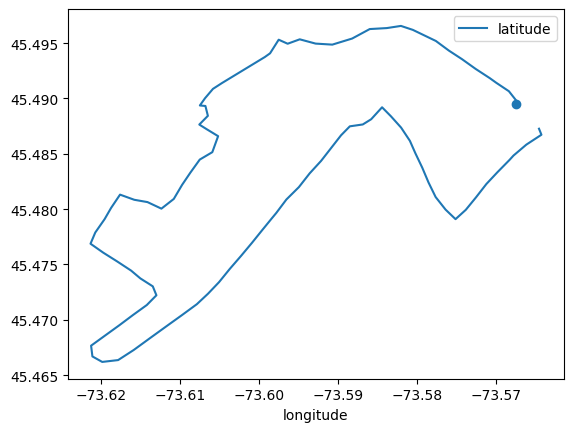

In [28]:
print(all_last_traces_info_df.index[index_longest_run].year, 
      all_last_traces_info_df.index[index_longest_run].month, 
      all_last_traces_info_df.index[index_longest_run].day)

index_longest_run = all_last_traces_info_df["cumulative_distance"].argmax()
one_long_run_df   = list_run_df[index_longest_run]

one_long_run_df.plot(x="longitude", y="latitude")
plt.scatter(startingPoint_df["longitude"][3],startingPoint_df["latitude"][3])

print(all_last_traces_info_df.index[index_longest_run].year, 
      all_last_traces_info_df.index[index_longest_run].month, 
      all_last_traces_info_df.index[index_longest_run].day)

## Show the shortest run

I migth have an issue herel, at least two:
+ I know the recorded data are for at least 9k
+ Despite reading correclty it only show a distance of 4k ish

2023 5 25


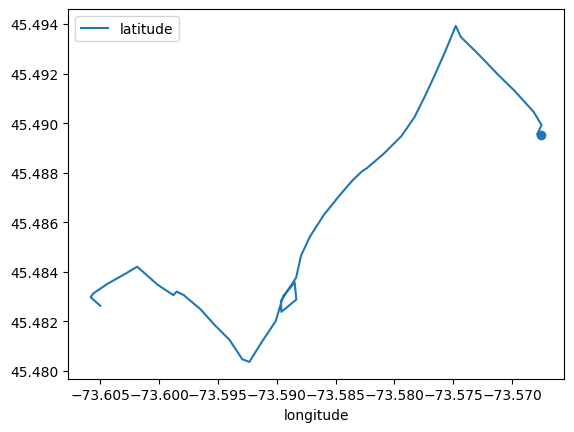

In [30]:
index_shortest_run = all_last_traces_info_df["cumulative_distance"].argmin()
one_long_run_df   = list_run_df[index_shortest_run]

one_long_run_df.plot(x="longitude", y="latitude")
plt.scatter(startingPoint_df["longitude"][3],startingPoint_df["latitude"][3])

print(all_last_traces_info_df.index[index_shortest_run].year, 
      all_last_traces_info_df.index[index_shortest_run].month, 
      all_last_traces_info_df.index[index_shortest_run].day)

# Display all distance per run

<Axes: xlabel='time'>

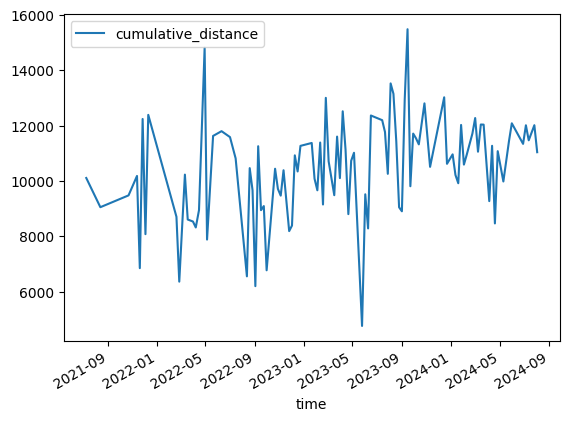

In [31]:
# All info is in all_last_traces_info_df at cumulative_distance
all_last_traces_info_df.plot.line(y="cumulative_distance")

# Answering questions

+ what is the longest run, when did it happen?
+ what is the average distance per year?
+ is there still some cleaning I can do? I can see at least two of my recorded runs are too small meaning my gps probably collapsed at those dates, so what are those dates?


In [15]:
index_longest_run = all_last_traces_info_df["cumulative_distance"].argmax()
one_long_run_df   = list_run_df[index_longest_run]

#one_long_run_df.plot(x="longitude", y="latitude")
#plt.scatter(startingPoint_df["longitude"][3],startingPoint_df["latitude"][3])

year   = all_last_traces_info_df.index[index_longest_run].year
month  = all_last_traces_info_df.index[index_longest_run].month 
day    = all_last_traces_info_df.index[index_longest_run].day
lenght = all_last_traces_info_df["cumulative_distance"].iloc[index_longest_run] / 1000

print("The longest did happen the Thursday {0:1.0f}-{1:1.0f}-{2:1.0f} and we ran {3:1.2f}km".format(year, month, day, lenght))

The longest did happen the Thursday 2023-9-15 and we ran 15.49km


# Some pre conclusions

From there we have:
+ loaded csv file to DataFrame for each gps trace
+ cleaned the gps trace to avoid recorded points before each race assuming I stop recording when the run was over
+ delivered some insite about all the runs I have the gps traces

# What's next?
I need to save some variables such that I can reload them in another notebook.

I can continue on generating dataviz.

In [16]:
all_last_traces_info_df.sort_values(by=['cumulative_distance'])

,cumulative_distance,indexNum
time,,
2023-05-25,4767.579072,54
2022-09-02,6205.181804,25
2022-02-25,6367.882944,9
2022-08-12,6558.92372,22
2022-09-30,6778.002426,29
...,...,...
2023-12-15,13025.900851,74
2023-08-11,13151.353305,62
2023-08-04,13527.938909,61
